In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd /gdrive/My Drive/TESI MATTEO IV

Mounted at /gdrive
/gdrive/My Drive/TESI MATTEO IV


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch

In [ ]:
import os
os.listdir()

['mimicIV_24h_diagnoses.csv',
 'mimicIV_24h_procedures.csv',
 'Embeddings Diagnoses Procedures',
 '24h_Procedures_embeddings.pkl',
 '90pca_transformed_embeddings_procedures.pkl',
 'mimicIV_24h_comorbidities.csv',
 '24h_Diagnoses_embeddings.pkl',
 '90pca_transformed_embeddings_diagnoses.pkl',
 'Prediction',
 'mimicIV_24h_complete_demo.csv',
 'mimicIV_24h_complete_blood.csv',
 'mimicIV_24h_complete_lab.csv',
 'mimicIV_24h_complete_art.csv',
 'mimicIV_24h_prescriptions.csv']

In [ ]:
df_prescriptions = pd.read_csv('mimicIV_24h_prescriptions.csv')
print(f"df shape: {df_prescriptions.shape}")

df shape: (3273606, 8)


In [ ]:
df_prescriptions.head()

,subject_id,hadm_id,stay_id,icu_admission_time,prescription_drug,prescription_dose,prescription_dose_unit,prescription_route
0,10000032,29079034,39553978,2180-07-23 14:00:00,Bisacodyl,10,mg,PR
1,10000032,29079034,39553978,2180-07-23 14:00:00,Senna,8.6,mg,PO
2,10000032,29079034,39553978,2180-07-23 14:00:00,Rifaximin,550,mg,PO/NG
3,10000032,29079034,39553978,2180-07-23 14:00:00,Bisacodyl,10,mg,PO
4,10000032,29079034,39553978,2180-07-23 14:00:00,Albumin 25% (12.5g / 50mL),50,g,IV


### COMPLETE ANALYSIS (remove nan values)

In [ ]:
# Filter out any rows that have at least one missing value
df_prescriptions = df_prescriptions.dropna()

print("Shape of DataFrame with complete cases:", df_prescriptions.shape)
df_prescriptions.head()

Shape of DataFrame with complete cases: (3270863, 8)


,subject_id,hadm_id,stay_id,icu_admission_time,prescription_drug,prescription_dose,prescription_dose_unit,prescription_route
0,10000032,29079034,39553978,2180-07-23 14:00:00,Bisacodyl,10,mg,PR
1,10000032,29079034,39553978,2180-07-23 14:00:00,Senna,8.6,mg,PO
2,10000032,29079034,39553978,2180-07-23 14:00:00,Rifaximin,550,mg,PO/NG
3,10000032,29079034,39553978,2180-07-23 14:00:00,Bisacodyl,10,mg,PO
4,10000032,29079034,39553978,2180-07-23 14:00:00,Albumin 25% (12.5g / 50mL),50,g,IV


### CONCATENATE LONG DIAGNOSES/PROCEDURES BY ICUSTAY_ID

In [ ]:
# Assuming df_prescription is your DataFrame
df_prescriptions['combined_info'] = df_prescriptions.apply(lambda x: f"{x['prescription_drug']} {x['prescription_dose']} {x['prescription_dose_unit']} {x['prescription_route']}", axis=1)
df_prescriptions.combined_info

0                          Bisacodyl 10 mg PR
1                             Senna 8.6 mg PO
2                      Rifaximin 550 mg PO/NG
3                          Bisacodyl 10 mg PO
4          Albumin 25% (12.5g / 50mL) 50 g IV
                          ...                
3273601         Iso-Osmotic Dextrose 50 mL IV
3273602                 Vancomycin 1000 mg IV
3273603       Fentanyl Citrate 2.5 mg IV DRIP
3273604               Propofol 200 mg IV DRIP
3273605              Venlafaxine XR 150 mg PO
Name: combined_info, Length: 3270863, dtype: object

In [ ]:
# Group by ICUSTAY_ID and concatenate medication strings
df_medication_profile = df_prescriptions.groupby('stay_id')['combined_info'].apply(lambda x: ' '.join(x)).reset_index()
print(df_medication_profile.shape)
df_medication_profile.head()

(40066, 2)


,stay_id,combined_info
0,30000153,Magnesium Sulfate 2 gm IV Metoprolol Tartrate ...
1,30000484,Multivitamins 1 TAB PO Albuterol 0.083% Neb So...
2,30001148,Pravastatin 20 mg PO CefazoLIN 2 gm IV Ranitid...
3,30001336,Magnesium Sulfate 2 gm IV Furosemide 20 mg IV ...
4,30001396,Insulin 0 UNIT SC Glucagon 1 mg IM Lisinopril ...


### EMBEDDINGS

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel

def load_model_with_retry(model_name, retries=5):
    for i in range(retries):
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModel.from_pretrained(model_name)
            return tokenizer, model
        except Exception as e:
            wait = 2 ** i
            print(f"Attempt {i+1} failed with error {e}. Retrying in {wait} seconds.")
            time.sleep(wait)
    raise Exception("Failed to load model after several retries.")

# Usage
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer, model = load_model_with_retry(model_name)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# Find the maximum length of the tokens
df = df_medication_profile.copy()
tokenizer_test = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing and analyzing lengths
df['token_length'] = df['combined_info'].apply(lambda x: len(tokenizer_test.tokenize(x)))

# Maximum token length for understanding the upper bound
max_length_maximum = df['token_length'].max()

print("Maximum token length in the dataset:", max_length_maximum)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1714 > 512). Running this sequence through the model will result in indexing errors


Maximum token length in the dataset: 10549


In [ ]:
def generate_embeddings_chunked(df, text_column, tokenizer, model, chunk_size=512):
    embeddings_dict = {}
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Embeddings"):
        text = row[text_column]
        icustay_id = row['stay_id']

        # Tokenize text and create overlapping chunks
        tokens = tokenizer.tokenize(text)
        chunks = [
            tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size - 100)
        ]  # Overlapping chunks to retain context

        chunk_embeddings = []
        for chunk in chunks:
            # Join tokens to form a string again, appropriate for encode_plus
            chunk_text = ' '.join(chunk)
            inputs = tokenizer.encode_plus(chunk_text, return_tensors="pt", padding='max_length', truncation=True, max_length=chunk_size)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze()
            chunk_embeddings.append(embedding)

        # Aggregate chunk embeddings by taking the mean
        if chunk_embeddings:
            embeddings_dict[icustay_id] = np.mean(chunk_embeddings, axis=0)
        else:
            embeddings_dict[icustay_id] = np.zeros((model.config.hidden_size,))  # Handle cases with no valid chunks

    return embeddings_dict



In [ ]:
import pickle

In [ ]:
sub_group1 = df_medication_profile.loc[0:10000,:]
sub_group2 = df_medication_profile.loc[10000:20000,:]
sub_group3 = df_medication_profile.loc[20000:30000,:]
sub_group4 = df_medication_profile.loc[30000:,:]

In [ ]:
medical_prescriptions_embeddings = generate_embeddings_chunked(sub_group1, 'combined_info', tokenizer, model,chunk_size=512)

MedicalPrescription_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/24h_1MedicalPrescription_embeddings.pkl'

with open(MedicalPrescription_embeddings_file, 'wb') as file:
    pickle.dump(medical_prescriptions_embeddings, file)

Generating Embeddings: 100%|██████████| 10001/10001 [3:28:06<00:00,  1.25s/it]


### IMPORT EMBEDDINGS

In [ ]:
# Define the paths to the embeddings files for each subgroup
subgroup_files = [
    '/gdrive/My Drive/TESI MATTEO IV/24h_1MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_2MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_3MedicalPrescription_embeddings.pkl',
    '/gdrive/My Drive/TESI MATTEO IV/24h_4MedicalPrescription_embeddings.pkl'
]

# Initialize an empty dictionary to hold all embeddings
all_embeddings = {}

# Load each file and merge the dictionaries
for file_path in subgroup_files:
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
        all_embeddings.update(embeddings)

df_prescriptions_grouped = pd.DataFrame(list(all_embeddings.items()), columns=['stay_id', 'Embeddings'])

# Display the head of the DataFrame to verify
print(df_prescriptions_grouped.shape)
df_prescriptions_grouped.head()

(40066, 2)


,stay_id,Embeddings
0,30000153,"[0.25422546, -0.019283248, -0.22589009, 0.4821..."
1,30000484,"[0.34430957, 0.080360144, -0.28666493, 0.51361..."
2,30001148,"[0.3176487, 0.01986816, -0.15024547, 0.4449668..."
3,30001336,"[0.3104475, -0.04064364, -0.27751422, 0.528819..."
4,30001396,"[0.1973952, 0.023247747, -0.2516353, 0.6550003..."


In [ ]:
# Assuming 'df_prescriptions_grouped' has columns 'ICUSTAY_ID' and 'Embeddings' where 'Embeddings' are numpy arrays
df_medication_profile = df_prescriptions_grouped.groupby('stay_id')['Embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()
df_medication_profile.columns = ['stay_id', 'Average_Embeddings']

# Display the head of the DataFrame to verify
print(df_medication_profile.shape)
df_medication_profile.head()

(40066, 2)


,stay_id,Average_Embeddings
0,30000153,"[0.25422546, -0.019283248, -0.22589009, 0.4821..."
1,30000484,"[0.34430957, 0.080360144, -0.28666493, 0.51361..."
2,30001148,"[0.3176487, 0.01986816, -0.15024547, 0.4449668..."
3,30001336,"[0.3104475, -0.04064364, -0.27751422, 0.528819..."
4,30001396,"[0.1973952, 0.023247747, -0.2516353, 0.6550003..."


### COMBINE EMBEDDINGS

In [ ]:
# Drop duplicates based on 'ICUSTAY_ID'
df_medication_profile = df_medication_profile.drop_duplicates(subset='stay_id')

# Ensure each embedding is actually a numpy array and stack them vertically
embeddings_list = df_medication_profile['Average_Embeddings'].tolist()
icustay_ids = df_medication_profile['stay_id'].values
combined_embeddings_matrix = np.vstack(embeddings_list)

# Verify the shape
print("Shape of combined embeddings matrix:", combined_embeddings_matrix.shape)

Shape of combined embeddings matrix: (40066, 768)


### STANDARDIZATION

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data prior to applying PCA
scaler = StandardScaler()
combined_embeddings_matrix_standardized = scaler.fit_transform(combined_embeddings_matrix)

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

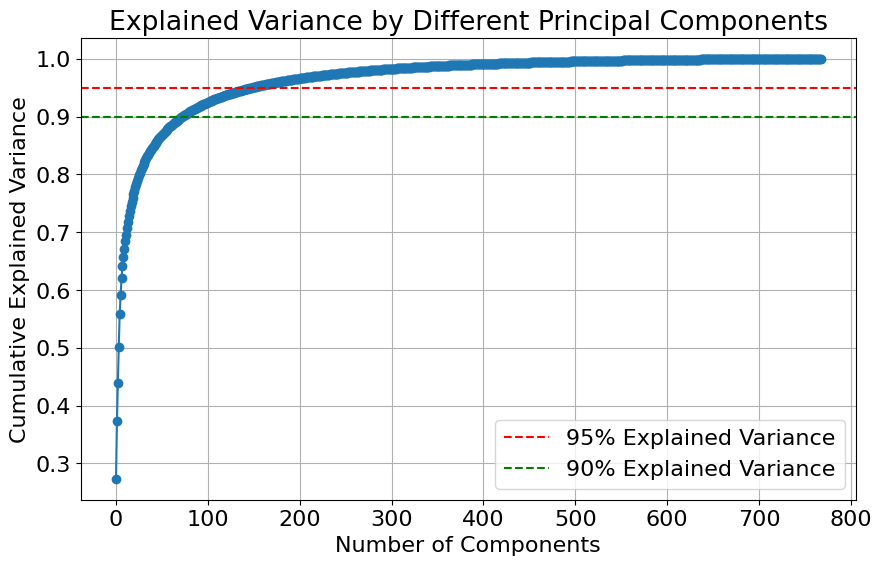

Number of components to explain 95% variance: 149
Number of components to explain 90% variance: 74


In [ ]:
pca = PCA().fit(combined_embeddings_matrix_standardized)

explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Find the number of components for 95% and 90% of explained variance
components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

print(f"Number of components to explain 95% variance: {components_95}")
print(f"Number of components to explain 90% variance: {components_90}")

In [ ]:
# Apply PCA with the optimal number of components found earlier
pca = PCA(n_components=components_90)
pca_transformed = pca.fit_transform(combined_embeddings_matrix_standardized)
pca_reconstructed = pca.inverse_transform(pca_transformed)

# Calculate MSE for PCA
pca_mse = mean_squared_error(combined_embeddings_matrix_standardized, pca_reconstructed)
print("PCA MSE:", pca_mse)

PCA MSE: 0.09939796


In [ ]:
# Combine PCA results back with ICUSTAY_ID
df_pca_transformed = pd.DataFrame(pca_transformed)
df_pca_transformed['stay_id'] = icustay_ids

# Verify structure
print(df_pca_transformed.head())

           0          1         2         3          4         5         6  \
0   1.073865  -2.847433 -1.884651 -1.806777  11.658655 -1.053775  1.137572   
1  11.940215   4.676190  2.859644  4.738493   7.126265 -6.970925 -0.253202   
2  12.894310  -0.977589  4.213163 -6.402776  13.828606  1.173164 -0.390070   
3  12.649960   7.031679  0.396800 -0.134898  -0.290172 -4.030871 -3.504396   
4  -0.678627  23.900223 -3.003009 -2.893336  -8.320085 -3.751412  3.453661   

           7         8         9  ...        65        66        67        68  \
0  -0.835539 -1.582541  0.310660  ... -0.097898 -0.407966 -0.236391 -0.243671   
1  -5.965274  2.820589  5.208686  ...  0.938400  0.251575  0.271786  0.124454   
2  -2.084018 -0.882702 -0.163734  ... -1.892574  0.183217  0.785127 -0.055333   
3  -5.390964  3.564844  8.530336  ...  0.338232  1.117433  0.953153  0.794848   
4  10.185772 -0.950944 -0.949990  ...  1.528522  2.482153 -2.996859 -0.280538   

         69        70        71        72   

In [ ]:
# Save the PCA-transformed embeddings to a file
pca_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/90pca_transformed_embeddings_prescription.pkl'

with open(pca_embeddings_file, 'wb') as file:
    pickle.dump(df_pca_transformed, file)